In [ ]:
# this code is still a bit of a mess
# I am not decided yet on how exactly I want to read and plot the data
# so there's a bunch of different reading/plotting/HZ selecting happening in this notebook

In [ ]:
import numpy as np
from matplotlib.pyplot import figure, show, subplots
from matplotlib import pyplot as plt
import ReadPlanetPopulation as RPP
import subprocess

#import yaml
from ruamel.yaml import YAML
yaml = YAML()
yaml.preserve_quotes = True  # Keep quotes if they exist
yaml.indent(mapping=2, sequence=4, offset=2)  # Preserve indentation
yaml.representer.add_representer(
    float, lambda dumper, data: dumper.represent_scalar("tag:yaml.org,2002:float", str(data))
)

with open("../config/masterconfig.yaml", "r") as file:
    config = yaml.load(file) or {}
PPOP_rootpath = config['PPOP_rootpath']
REPO_rootpath = config['REPO_path']

In [ ]:
# write config file to p-pop repo
prompt = "cp -f " + "../config/P-pop.py " + PPOP_rootpath
subprocess.run(prompt, shell=True)

# run p-pop
prompt = "python3 P-pop.py"
subprocess.run(prompt,cwd=PPOP_rootpath, shell=True)

# get population data file
prompt = "cp -f " + PPOP_rootpath + "/planet_population.txt " + "../output"
subprocess.run(prompt, shell=True)

In [ ]:
data = np.genfromtxt("../output/planet_population.txt",skip_header=2)
titles = np.genfromtxt("../output/planet_population.txt",dtype='str')[1]

def select_universe(i):
    def filter_func(x):
        if x[0] == i:
            return True
        else:
            return False
    return np.array(list(filter(filter_func,data[:,0:3])))

universe0 = select_universe(0)
universe1 = select_universe(1)
universe2 = select_universe(2)

[[  0.        1.52995   7.14182]
 [  0.        0.7925   21.41471]
 [  0.        0.54799 161.8837 ]
 ...
 [  0.        0.75713   7.12492]
 [  0.        1.62053  35.5743 ]
 [  0.        0.82962  88.50298]]


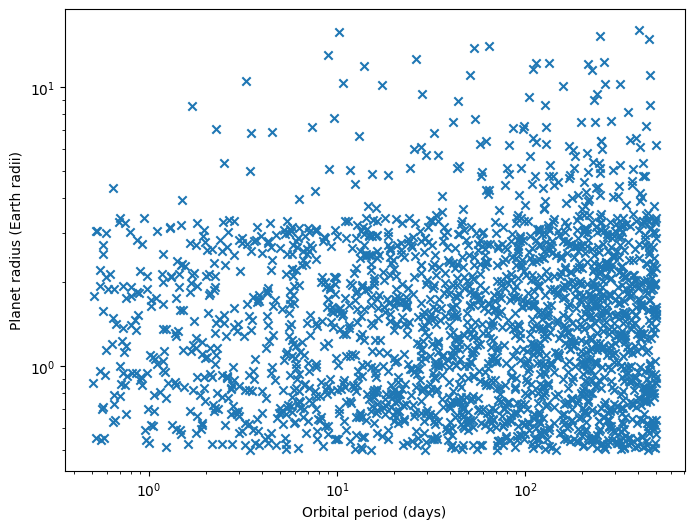

In [24]:
fig = figure(figsize=(8,6))
frame1 = fig.add_subplot(1,1,1)

frame1.scatter(universe0[:,2],universe0[:,1],marker='x')
#frame1.scatter(universe1[:,2],universe1[:,1],marker='*')
#frame1.scatter(universe2[:,2],universe2[:,1],marker='+')

frame1.set_xlabel('Orbital period (days)')
frame1.set_ylabel('Planet radius (Earth radii)')
frame1.set_xscale('log')
frame1.set_yscale('log')
show()

In [31]:
# Select the name of the planet population table to be read.
PathPlanetTable = "../output/planet_population.txt" # str

# Select a model for the computation of the habitable zone.
Model = 'MS'
#Model = 'POST-MS'

PP = RPP.PlanetPopulation(PathPlanetTable)
PP.ComputeHZ(Model)

ww_Rp = (PP.Rp > 0.5) & (PP.Rp < 1.5)
ww_Fp = (PP.Fp < PP.HZin) & (PP.Fp > PP.HZout)
ww_habitable = ww_Rp & ww_Fp

#import pdb; pdb.set_trace()

--> Reading planet table ../output/planet_population.txt
Processed line 0 of 20171

Processed line 20171 of 20171
--> Computing the habitable zone
--> Using model MS


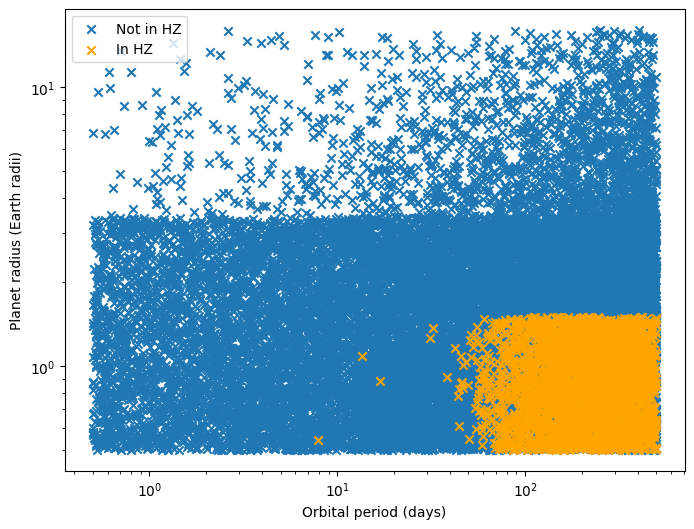

In [32]:
fig = figure(figsize=(8,6))
frame1 = fig.add_subplot(1,1,1)

#frame1.scatter(universe0[:,2],universe0[:,1],marker='x',label="Not in HZ")
#frame1.scatter(habitableplanets[:,2],habitableplanets[:,1],marker='x',c="orange",label="In HZ")
frame1.scatter(data[:,2],data[:,1],marker='x',label="Not in HZ")
frame1.scatter(data[ww_habitable][:,2],data[ww_habitable][:,1],marker='x',c="orange",label="In HZ")

frame1.set_xlabel('Orbital period (days)')
frame1.set_ylabel('Planet radius (Earth radii)')
frame1.set_xscale('log')
frame1.set_yscale('log')
frame1.legend()
show()

--> Reading planet table ../output/planet_population.txt
Processed line 0 of 20171

Processed line 20171 of 20171


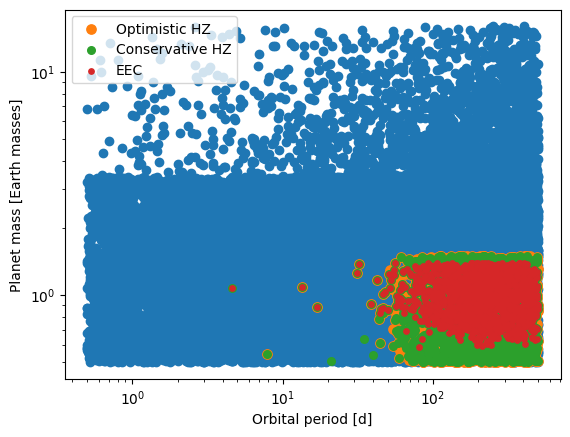

In [36]:
PathPlanetTable = "../output/planet_population.txt" # str
PP = RPP.PlanetPopulation(PathPlanetTable)

# Optimistic HZ.
ww_Rp = (PP.Rp > 0.5) & (PP.Rp < 1.5)
Ts = PP.Ts - 5780.
ww_Fp = (PP.Fp > (0.320 + 5.547e-5 * Ts + 1.526e-9 * Ts**2 - 2.874e-12 * Ts**3 - 5.011e-16 * Ts**4)) & (PP.Fp < (1.776 + 2.136e-4 * Ts +  2.533e-8 * Ts**2 - 1.332e-11 * Ts**3 - 3.097e-15 * Ts**4))
ww_optHZ = ww_Rp & ww_Fp

# Conservative HZ.
ww_Rp = (PP.Rp > 0.5) & (PP.Rp < 1.5)
Ts = PP.Ts - 5780.
ww_Fp = (PP.Fp > (0.356 + 6.171e-5 * Ts + 1.698e-9 * Ts**2 - 3.198e-12 * Ts**3 - 5.575e-16 * Ts**4)) & (PP.Fp < (1.107 + 1.332e-4 * Ts +  1.580e-8 * Ts**2 - 8.308e-11 * Ts**3 - 1.931e-15 * Ts**4))
ww_conHZ = ww_Rp & ww_Fp

# EEC.
ww_Rp = (PP.Rp > 0.8 * PP.Fp**(0.25)) & (PP.Rp < 1.4)
Ts = PP.Ts - 5780.
ww_Fp = (PP.Fp > (0.356 + 6.171e-5 * Ts + 1.698e-9 * Ts**2 - 3.198e-12 * Ts**3 - 5.575e-16 * Ts**4)) & (PP.Fp < (1.107 + 1.332e-4 * Ts +  1.580e-8 * Ts**2 - 8.308e-11 * Ts**3 - 1.931e-15 * Ts**4))
ww_EEC = ww_Rp & ww_Fp

# Plot.
plt.figure()
plt.scatter(PP.Porb, PP.Rp)
plt.scatter(PP.Porb[ww_optHZ], PP.Rp[ww_optHZ], s=45, label='Optimistic HZ')
plt.scatter(PP.Porb[ww_conHZ], PP.Rp[ww_conHZ], s=30, label='Conservative HZ')
plt.scatter(PP.Porb[ww_EEC], PP.Rp[ww_EEC], s=15, label='EEC')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Orbital period [d]')
plt.ylabel('Planet mass [Earth masses]')
plt.legend()
plt.savefig("../output/figures/planetpop_massorbit_plot.png")
plt.show()

#import pdb; pdb.set_trace()